In [ ]:
!pip install kagglehub transformers datasets accelerate torch

import kagglehub
import pandas as pd
from datasets import Dataset
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
import torch



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import os
import pandas as pd
import kagglehub

# Download dataset
path = kagglehub.dataset_download("mazlumi/ielts-writing-scored-essays-dataset")
print("Path to dataset files:", path)

# Check the files in the directory
for root, dirs, files in os.walk(path):
    print(f"Root: {root}")
    print(f"Directories: {dirs}")
    print(f"Files: {files}")

# Correct file name
csv_file = os.path.join(path, "ielts_writing_dataset.csv")

# Load the dataset into a DataFrame
try:
    df = pd.read_csv(csv_file)
    print("Dataset loaded successfully!")
    print(df.head())  # Display first few rows
except FileNotFoundError:
    print(f"File not found: {csv_file}. Please verify the dataset structure.")



100%|██████████| 674k/674k [00:00<00:00, 68.6MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/mazlumi/ielts-writing-scored-essays-dataset/versions/1
Root: /root/.cache/kagglehub/datasets/mazlumi/ielts-writing-scored-essays-dataset/versions/1
Directories: []
Files: ['ielts_writing_dataset.csv']


Dataset loaded successfully!
   Task_Type                                           Question  \
0          1  The bar chart below describes some changes abo...   
1          2  Rich countries often give money to poorer coun...   
2          1  The bar chart below describes some changes abo...   
3          2  Rich countries often give money to poorer coun...   
4          1  The graph below shows the number of overseas v...   

                                               Essay Examiner_Commen  \
0  Between 1995 and 2010, a study was conducted r...             NaN   
1  Poverty represents a worldwide crisis. It is t...             NaN   
2  The left chart shows the population change hap...             NaN   
3  Human beings are facing many challenges nowada...             NaN   
4  Information about the thousands of visits from...             NaN   

   Task_Response  Coherence_Cohesion  Lexical_Resource  Range_Accuracy  \
0            NaN                 NaN               NaN       

In [ ]:
# Drop rows with NaN in the 'Overall' column
df = df.dropna(subset=["Overall"])

# Combine Question and Essay for model input
df["combined_text"] = df["Question"] + " " + df["Essay"]

# Split dataset
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_scores, val_scores = train_test_split(
    df["combined_text"], df["Overall"], test_size=0.2, random_state=42
)


In [ ]:
from transformers import BertTokenizer

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the data
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=512)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
import torch

class EssayDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, scores):
        self.encodings = encodings
        self.scores = scores

    def __len__(self):
        return len(self.scores)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.scores[idx], dtype=torch.float)
        return item

# Create datasets
train_dataset = EssayDataset(train_encodings, train_scores.tolist())
val_dataset = EssayDataset(val_encodings, val_scores.tolist())


In [ ]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Train the model
trainer.train()


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,1.660900,1.049642
2,0.871700,1.422862
3,0.607300,0.675685


TrainOutput(global_step=432, training_loss=8.155342089909094, metrics={'train_runtime': 420.5101, 'train_samples_per_second': 8.19, 'train_steps_per_second': 1.027, 'total_flos': 906146338664448.0, 'train_loss': 8.155342089909094, 'epoch': 3.0})

In [ ]:
# Evaluate on validation set
results = trainer.evaluate()
print("Validation Results:", results)





Validation Results: {'eval_loss': 0.6756852269172668, 'eval_model_preparation_time': 0.0056, 'eval_rmse': 0.8220007825555348, 'eval_mae': 0.652375340461731, 'eval_r2': 0.34896302223205566, 'eval_runtime': 7.7494, 'eval_samples_per_second': 37.035, 'eval_steps_per_second': 2.323}


In [ ]:
print(trainer.state.log_history)

[{'eval_loss': 0.6756852269172668, 'eval_model_preparation_time': 0.0056, 'eval_rmse': 0.8220007825555348, 'eval_mae': 0.652375340461731, 'eval_r2': 0.34896302223205566, 'eval_runtime': 8.0838, 'eval_samples_per_second': 35.503, 'eval_steps_per_second': 2.227, 'step': 0}, {'eval_loss': 0.6756852269172668, 'eval_model_preparation_time': 0.0056, 'eval_rmse': 0.8220007825555348, 'eval_mae': 0.652375340461731, 'eval_r2': 0.34896302223205566, 'eval_runtime': 7.5819, 'eval_samples_per_second': 37.853, 'eval_steps_per_second': 2.374, 'step': 0}, {'eval_loss': 0.6756852269172668, 'eval_model_preparation_time': 0.0056, 'eval_rmse': 0.8220007825555348, 'eval_mae': 0.652375340461731, 'eval_r2': 0.34896302223205566, 'eval_runtime': 7.7494, 'eval_samples_per_second': 37.035, 'eval_steps_per_second': 2.323, 'step': 0}]


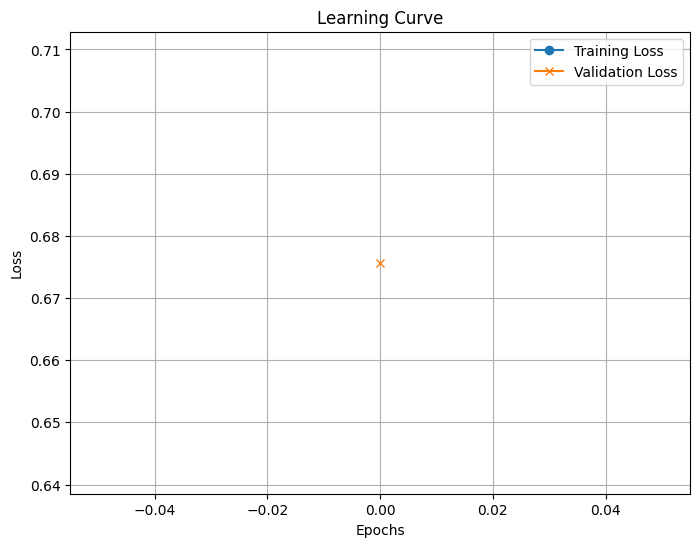

In [ ]:
import matplotlib.pyplot as plt

# Retrieve logged metrics
training_logs = trainer.state.log_history

# Extract loss values
train_loss = [log["loss"] for log in training_logs if "loss" in log]
eval_loss = [log["eval_loss"] for log in training_logs if "eval_loss" in log]

# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label="Training Loss", marker="o")
plt.plot(eval_loss, label="Validation Loss", marker="x")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend()
plt.grid()
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define custom compute_metrics function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.squeeze()  # Remove extra dimensions if needed

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(labels, predictions))
    mae = mean_absolute_error(labels, predictions)
    r2 = r2_score(labels, predictions)

    return {"rmse": rmse, "mae": mae, "r2": r2}

# Update the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Evaluate the model
results = trainer.evaluate()
print("Evaluation Results:", results)


# Get predictions on validation set
predictions = trainer.predict(val_dataset)
preds = predictions.predictions.squeeze()  # Flatten predictions if necessary
labels = predictions.label_ids

# Calculate metrics
rmse = np.sqrt(mean_squared_error(labels, preds))
mae = mean_absolute_error(labels, preds)
r2 = r2_score(labels, preds)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")


Evaluation Results: {'eval_loss': 0.6756852269172668, 'eval_model_preparation_time': 0.0056, 'eval_rmse': 0.8220007825555348, 'eval_mae': 0.652375340461731, 'eval_r2': 0.34896302223205566, 'eval_runtime': 8.0838, 'eval_samples_per_second': 35.503, 'eval_steps_per_second': 2.227}
RMSE: 0.8220
MAE: 0.6524
R²: 0.3490


In [ ]:
# Get predictions on validation set
predictions = trainer.predict(val_dataset)

# Flatten predictions and get true labels
preds = predictions.predictions.squeeze()  # Flatten predictions if necessary
labels = predictions.label_ids  # True scores from the dataset

# Convert to lists for display
predicted_scores = preds.tolist()
true_scores = labels.tolist()



# Round predictions to the nearest 0.5
rounded_preds = [round(pred * 2) / 2 for pred in predicted_scores]



# Create the list with predicted, rounded predicted, and true scores
results = []

for predicted, rounded, true in zip(predicted_scores, rounded_preds, true_scores):
    results.append({
        "Predicted": predicted,
        "Rounded Predicted": rounded,
        "True": true
    })

# Print the results

for item in results:
    print(item)



{'Predicted': 6.142123699188232, 'Rounded Predicted': 6.0, 'True': 6.5}
{'Predicted': 7.65435791015625, 'Rounded Predicted': 7.5, 'True': 7.5}
{'Predicted': 5.480889320373535, 'Rounded Predicted': 5.5, 'True': 7.0}
{'Predicted': 7.057538986206055, 'Rounded Predicted': 7.0, 'True': 6.0}
{'Predicted': 5.880197048187256, 'Rounded Predicted': 6.0, 'True': 5.5}
{'Predicted': 7.598631858825684, 'Rounded Predicted': 7.5, 'True': 6.5}
{'Predicted': 6.5631208419799805, 'Rounded Predicted': 6.5, 'True': 6.5}
{'Predicted': 8.173510551452637, 'Rounded Predicted': 8.0, 'True': 8.0}
{'Predicted': 6.275651931762695, 'Rounded Predicted': 6.5, 'True': 6.5}
{'Predicted': 7.525610446929932, 'Rounded Predicted': 7.5, 'True': 6.5}
{'Predicted': 6.324029922485352, 'Rounded Predicted': 6.5, 'True': 6.5}
{'Predicted': 6.901822566986084, 'Rounded Predicted': 7.0, 'True': 5.5}
{'Predicted': 6.670233249664307, 'Rounded Predicted': 6.5, 'True': 5.5}
{'Predicted': 6.984334468841553, 'Rounded Predicted': 7.0, 'True

Path to dataset files: /root/.cache/kagglehub/datasets/mazlumi/ielts-writing-scored-essays-dataset/versions/1
Root: /root/.cache/kagglehub/datasets/mazlumi/ielts-writing-scored-essays-dataset/versions/1
Directories: []
Files: ['ielts_writing_dataset.csv']
Dataset loaded successfully!
   Task_Type                                           Question  \
0          1  The bar chart below describes some changes abo...   
1          2  Rich countries often give money to poorer coun...   
2          1  The bar chart below describes some changes abo...   
3          2  Rich countries often give money to poorer coun...   
4          1  The graph below shows the number of overseas v...   

                                               Essay Examiner_Commen  \
0  Between 1995 and 2010, a study was conducted r...             NaN   
1  Poverty represents a worldwide crisis. It is t...             NaN   
2  The left chart shows the population change hap...             NaN   
3  Human beings are faci

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Rmse,Mae,R2
1,1.916800,1.154349,1.074406,0.870294,-0.017491
2,0.925800,1.932057,1.389984,1.178379,-0.702994
3,0.531700,1.252260,1.119044,0.883386,-0.103794


Validation Results: {'eval_loss': 1.1543492078781128, 'eval_rmse': 1.074406444451127, 'eval_mae': 0.870294451713562, 'eval_r2': -0.01749110221862793, 'eval_runtime': 4.1149, 'eval_samples_per_second': 34.751, 'eval_steps_per_second': 2.187, 'epoch': 3.0}


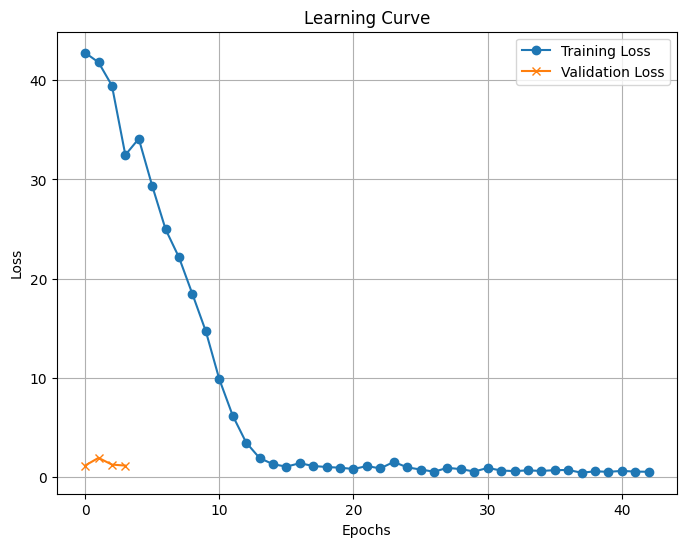

Test RMSE: 0.9732
Test MAE: 0.7754
Test R²: -0.0103
{'Predicted': 6.490827560424805, 'Rounded Predicted': 6.5, 'True': 6.5}
{'Predicted': 6.589778900146484, 'Rounded Predicted': 6.5, 'True': 7.5}
{'Predicted': 6.531445026397705, 'Rounded Predicted': 6.5, 'True': 6.5}
{'Predicted': 6.6569390296936035, 'Rounded Predicted': 6.5, 'True': 5.0}
{'Predicted': 6.560543537139893, 'Rounded Predicted': 6.5, 'True': 5.5}
{'Predicted': 6.534297466278076, 'Rounded Predicted': 6.5, 'True': 7.0}
{'Predicted': 6.553308486938477, 'Rounded Predicted': 6.5, 'True': 6.0}
{'Predicted': 6.652617931365967, 'Rounded Predicted': 6.5, 'True': 8.0}
{'Predicted': 6.489702224731445, 'Rounded Predicted': 6.5, 'True': 7.0}
{'Predicted': 6.508692264556885, 'Rounded Predicted': 6.5, 'True': 7.5}
{'Predicted': 6.561366558074951, 'Rounded Predicted': 6.5, 'True': 7.0}
{'Predicted': 6.566661834716797, 'Rounded Predicted': 6.5, 'True': 6.0}
{'Predicted': 6.545246601104736, 'Rounded Predicted': 6.5, 'True': 8.0}
{'Predicted

In [ ]:
!pip install kagglehub transformers datasets accelerate torch

import kagglehub
import pandas as pd
from datasets import Dataset
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Download dataset
path = kagglehub.dataset_download("mazlumi/ielts-writing-scored-essays-dataset")
print("Path to dataset files:", path)

# Check the files in the directory
for root, dirs, files in os.walk(path):
    print(f"Root: {root}")
    print(f"Directories: {dirs}")
    print(f"Files: {files}")

# Correct file name
csv_file = os.path.join(path, "ielts_writing_dataset.csv")

# Load the dataset into a DataFrame
try:
    df = pd.read_csv(csv_file)
    print("Dataset loaded successfully!")
    print(df.head())  # Display first few rows
except FileNotFoundError:
    print(f"File not found: {csv_file}. Please verify the dataset structure.")
# Handle missing values in your dataset
df.dropna(inplace=True)
# Drop rows with NaN in the 'Overall' column
df = df.dropna(subset=["Overall"])

# Combine Question and Essay for model input
df["combined_text"] = df["Question"] + " " + df["Essay"]

# Split dataset into 80% training, 10% validation, and 10% test
train_texts, temp_texts, train_scores, temp_scores = train_test_split(
    df["combined_text"], df["Overall"], test_size=0.2, random_state=42
)
val_texts, test_texts, val_scores, test_scores = train_test_split(
    temp_texts, temp_scores, test_size=0.5, random_state=42
)



# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the data
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=512)

class EssayDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, scores):
        self.encodings = encodings
        self.scores = scores

    def __len__(self):
        return len(self.scores)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.scores[idx], dtype=torch.float)
        return item

# Create datasets
train_dataset = EssayDataset(train_encodings, train_scores.tolist())
val_dataset = EssayDataset(val_encodings, val_scores.tolist())
test_dataset = EssayDataset(test_encodings, test_scores.tolist())


# Initialize model
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)




# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

# Define custom compute_metrics function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.squeeze()  # Remove extra dimensions if needed

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(labels, predictions))
    mae = mean_absolute_error(labels, predictions)
    r2 = r2_score(labels, predictions)

    return {"rmse": rmse, "mae": mae, "r2": r2}

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Evaluate on validation set
results = trainer.evaluate()
print("Validation Results:", results)

# Retrieve logged metrics for loss plotting
training_logs = trainer.state.log_history
train_loss = [log["loss"] for log in training_logs if "loss" in log]
eval_loss = [log["eval_loss"] for log in training_logs if "eval_loss" in log]

# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label="Training Loss", marker="o")
plt.plot(eval_loss, label="Validation Loss", marker="x")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend()
plt.grid()
plt.show()

# Get predictions on test set
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.squeeze()  # Flatten predictions if necessary
labels = predictions.label_ids

# Calculate metrics
rmse = np.sqrt(mean_squared_error(labels, preds))
mae = mean_absolute_error(labels, preds)
r2 = r2_score(labels, preds)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R²: {r2:.4f}")

# Round predictions to the nearest 0.5
rounded_preds = [round(pred * 2) / 2 for pred in preds]

# Create the list with predicted, rounded predicted, and true scores
results = []
for predicted, rounded, true in zip(preds.tolist(), rounded_preds, labels.tolist()):
    results.append({
        "Predicted": predicted,
        "Rounded Predicted": rounded,
        "True": true
    })

# Print the results
for item in results:
    print(item)


Path to dataset files: /root/.cache/kagglehub/datasets/mazlumi/ielts-writing-scored-essays-dataset/versions/1
Root: /root/.cache/kagglehub/datasets/mazlumi/ielts-writing-scored-essays-dataset/versions/1
Directories: []
Files: ['ielts_writing_dataset.csv']
Dataset loaded successfully!
   Task_Type                                           Question  \
0          1  The bar chart below describes some changes abo...   
1          2  Rich countries often give money to poorer coun...   
2          1  The bar chart below describes some changes abo...   
3          2  Rich countries often give money to poorer coun...   
4          1  The graph below shows the number of overseas v...   

                                               Essay Examiner_Commen  \
0  Between 1995 and 2010, a study was conducted r...             NaN   
1  Poverty represents a worldwide crisis. It is t...             NaN   
2  The left chart shows the population change hap...             NaN   
3  Human beings are faci

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Rmse,Mae,R2
1,1.334400,1.101534,1.049540,0.858892,0.029063
2,1.147700,0.990161,0.995068,0.805319,0.127231
3,0.455400,0.938250,0.968633,0.744610,0.172988


Validation Results: {'eval_loss': 0.938249945640564, 'eval_rmse': 0.9686330293979056, 'eval_mae': 0.7446103692054749, 'eval_r2': 0.17298775911331177, 'eval_runtime': 4.0376, 'eval_samples_per_second': 35.417, 'eval_steps_per_second': 2.229, 'epoch': 3.0}


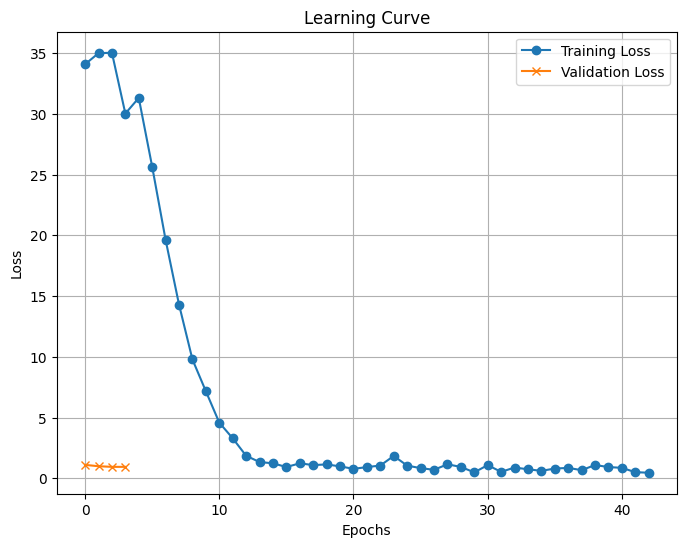

Test RMSE: 0.9212
Test MAE: 0.7160
Test R²: 0.0948
{'Predicted': 6.451474189758301, 'Rounded Predicted': 6.5, 'True': 6.5}
{'Predicted': 7.654829502105713, 'Rounded Predicted': 7.5, 'True': 7.5}
{'Predicted': 6.626684188842773, 'Rounded Predicted': 6.5, 'True': 6.5}
{'Predicted': 5.055272579193115, 'Rounded Predicted': 5.0, 'True': 5.0}
{'Predicted': 6.574045658111572, 'Rounded Predicted': 6.5, 'True': 5.5}
{'Predicted': 6.297459602355957, 'Rounded Predicted': 6.5, 'True': 7.0}
{'Predicted': 6.961911678314209, 'Rounded Predicted': 7.0, 'True': 6.0}
{'Predicted': 8.334070205688477, 'Rounded Predicted': 8.5, 'True': 8.0}
{'Predicted': 7.809981346130371, 'Rounded Predicted': 8.0, 'True': 7.0}
{'Predicted': 8.42374038696289, 'Rounded Predicted': 8.5, 'True': 7.5}
{'Predicted': 7.69138240814209, 'Rounded Predicted': 7.5, 'True': 7.0}
{'Predicted': 7.670555114746094, 'Rounded Predicted': 7.5, 'True': 6.0}
{'Predicted': 8.4181489944458, 'Rounded Predicted': 8.5, 'True': 8.0}
{'Predicted': 6.2

In [ ]:
import kagglehub
import pandas as pd
from datasets import Dataset
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Download dataset
path = kagglehub.dataset_download("mazlumi/ielts-writing-scored-essays-dataset")
print("Path to dataset files:", path)

# Check the files in the directory
for root, dirs, files in os.walk(path):
    print(f"Root: {root}")
    print(f"Directories: {dirs}")
    print(f"Files: {files}")

# Correct file name
csv_file = os.path.join(path, "ielts_writing_dataset.csv")

# Load the dataset into a DataFrame
try:
    df = pd.read_csv(csv_file)
    print("Dataset loaded successfully!")
    print(df.head())  # Display first few rows
except FileNotFoundError:
    print(f"File not found: {csv_file}. Please verify the dataset structure.")

# Drop rows where 'Overall' column is NaN
df = df.dropna(subset=["Overall"])

# Combine Question and Essay for model input
df["combined_text"] = df["Question"] + " " + df["Essay"]

# Check dataset size after dropping rows
print(f"Dataset size after dropping rows with NaN in 'Overall': {df.shape}")

# Now proceed with the train-test split
train_texts, temp_texts, train_scores, temp_scores = train_test_split(
    df["combined_text"], df["Overall"], test_size=0.2, random_state=42
)
val_texts, test_texts, val_scores, test_scores = train_test_split(
    temp_texts, temp_scores, test_size=0.5, random_state=42
)

# Combine Question and Essay for model input
df["combined_text"] = df["Question"] + " " + df["Essay"]

# Split dataset into 80% training, 10% validation, and 10% test
train_texts, temp_texts, train_scores, temp_scores = train_test_split(
    df["combined_text"], df["Overall"], test_size=0.2, random_state=42
)
val_texts, test_texts, val_scores, test_scores = train_test_split(
    temp_texts, temp_scores, test_size=0.5, random_state=42
)

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the data
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=512)

class EssayDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, scores):
        self.encodings = encodings
        self.scores = scores

    def __len__(self):
        return len(self.scores)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.scores[idx], dtype=torch.float)
        return item

# Create datasets
train_dataset = EssayDataset(train_encodings, train_scores.tolist())
val_dataset = EssayDataset(val_encodings, val_scores.tolist())
test_dataset = EssayDataset(test_encodings, test_scores.tolist())

# Initialize model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

# Define custom compute_metrics function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.squeeze()  # Remove extra dimensions if needed

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(labels, predictions))
    mae = mean_absolute_error(labels, predictions)
    r2 = r2_score(labels, predictions)

    return {"rmse": rmse, "mae": mae, "r2": r2}

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Evaluate on validation set
results = trainer.evaluate()
print("Validation Results:", results)

# Retrieve logged metrics for loss plotting
training_logs = trainer.state.log_history
train_loss = [log["loss"] for log in training_logs if "loss" in log]
eval_loss = [log["eval_loss"] for log in training_logs if "eval_loss" in log]

# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label="Training Loss", marker="o")
plt.plot(eval_loss, label="Validation Loss", marker="x")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend()
plt.grid()
plt.show()

# Get predictions on test set
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.squeeze()  # Flatten predictions if necessary
labels = predictions.label_ids

# Calculate metrics
rmse = np.sqrt(mean_squared_error(labels, preds))
mae = mean_absolute_error(labels, preds)
r2 = r2_score(labels, preds)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R²: {r2:.4f}")

# Round predictions to the nearest 0.5
rounded_preds = [round(pred * 2) / 2 for pred in preds]

# Create the list with predicted, rounded predicted, and true scores
results = []
for predicted, rounded, true in zip(preds.tolist(), rounded_preds, labels.tolist()):
    results.append({
        "Predicted": predicted,
        "Rounded Predicted": rounded,
        "True": true
    })

# Print the results
for item in results:
    print(item)


100%|██████████| 674k/674k [00:00<00:00, 790kB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mazlumi/ielts-writing-scored-essays-dataset/versions/1
Root: /root/.cache/kagglehub/datasets/mazlumi/ielts-writing-scored-essays-dataset/versions/1
Directories: []
Files: ['ielts_writing_dataset.csv']
Dataset loaded successfully!
   Task_Type                                           Question  \
0          1  The bar chart below describes some changes abo...   
1          2  Rich countries often give money to poorer coun...   
2          1  The bar chart below describes some changes abo...   
3          2  Rich countries often give money to poorer coun...   
4          1  The graph below shows the number of overseas v...   

                                               Essay Examiner_Commen  \
0  Between 1995 and 2010, a study was conducted r...             NaN   
1  Poverty represents a worldwide crisis. It is t...             NaN   
2  The left chart shows the population change hap...             NaN   
3  Human beings are faci

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Rmse,Mae,R2
1,31.496800,27.941748,5.285996,5.168715,-23.629017
2,11.859800,10.424103,3.228638,3.011148,-8.188233
3,2.024900,1.383202,1.176096,0.924479,-0.219211
4,1.129800,1.707730,1.306801,1.093308,-0.505264
5,0.975800,1.855959,1.362336,1.128087,-0.635919
6,0.858300,1.689883,1.299955,1.067777,-0.489533


Validation Results: {'eval_loss': 1.3832018375396729, 'eval_rmse': 1.1760959647623928, 'eval_mae': 0.9244785904884338, 'eval_r2': -0.21921122074127197, 'eval_runtime': 4.2808, 'eval_samples_per_second': 33.405, 'eval_steps_per_second': 1.168, 'epoch': 6.0}


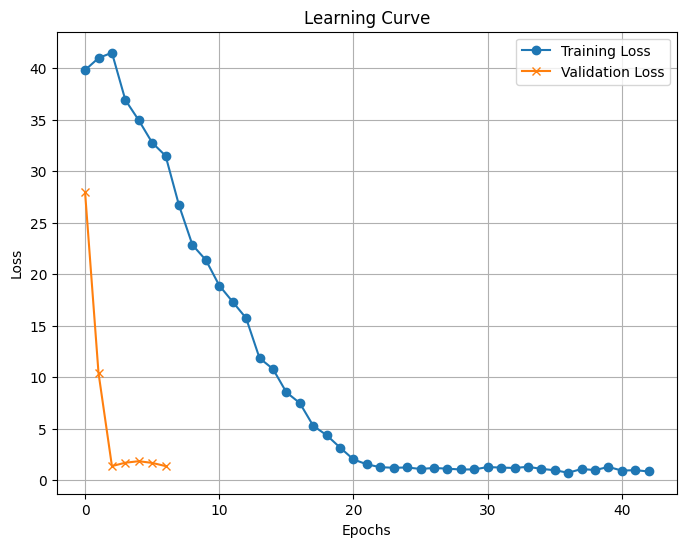

Test RMSE: 1.0977
Test MAE: 0.8714
Test R²: -0.2852
{'Predicted': 6.304819107055664, 'Rounded Predicted': 6.5, 'True': 6.5}
{'Predicted': 6.26077127456665, 'Rounded Predicted': 6.5, 'True': 7.5}
{'Predicted': 6.378549098968506, 'Rounded Predicted': 6.5, 'True': 6.5}
{'Predicted': 6.422577381134033, 'Rounded Predicted': 6.5, 'True': 5.0}
{'Predicted': 6.238845348358154, 'Rounded Predicted': 6.0, 'True': 5.5}
{'Predicted': 6.367668151855469, 'Rounded Predicted': 6.5, 'True': 7.0}
{'Predicted': 6.430250644683838, 'Rounded Predicted': 6.5, 'True': 6.0}
{'Predicted': 5.93299674987793, 'Rounded Predicted': 6.0, 'True': 8.0}
{'Predicted': 6.271047592163086, 'Rounded Predicted': 6.5, 'True': 7.0}
{'Predicted': 6.305256366729736, 'Rounded Predicted': 6.5, 'True': 7.5}
{'Predicted': 6.164097785949707, 'Rounded Predicted': 6.0, 'True': 7.0}
{'Predicted': 6.0248188972473145, 'Rounded Predicted': 6.0, 'True': 6.0}
{'Predicted': 6.009328842163086, 'Rounded Predicted': 6.0, 'True': 8.0}
{'Predicted':

In [ ]:
import kagglehub
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.model_selection import train_test_split
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Download dataset
path = kagglehub.dataset_download("mazlumi/ielts-writing-scored-essays-dataset")
print("Path to dataset files:", path)

# Check the files in the directory
for root, dirs, files in os.walk(path):
    print(f"Root: {root}")
    print(f"Directories: {dirs}")
    print(f"Files: {files}")

# Correct file name
csv_file = os.path.join(path, "ielts_writing_dataset.csv")

# Load the dataset into a DataFrame
try:
    df = pd.read_csv(csv_file)
    print("Dataset loaded successfully!")
    print(df.head())  # Display first few rows
except FileNotFoundError:
    print(f"File not found: {csv_file}. Please verify the dataset structure.")

# Drop rows where 'Overall' column is NaN
df = df.dropna(subset=["Overall"])

# Combine Question and Essay for model input
df["combined_text"] = df["Question"] + " " + df["Essay"]

# Check dataset size after dropping rows
print(f"Dataset size after dropping rows with NaN in 'Overall': {df.shape}")

# Train-test split
train_texts, temp_texts, train_scores, temp_scores = train_test_split(
    df["combined_text"], df["Overall"], test_size=0.2, random_state=42
)
val_texts, test_texts, val_scores, test_scores = train_test_split(
    temp_texts, temp_scores, test_size=0.5, random_state=42
)

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the data
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=512)

class EssayDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, scores):
        self.encodings = encodings
        self.scores = scores

    def __len__(self):
        return len(self.scores)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.scores[idx], dtype=torch.float)
        return item

# Create datasets
train_dataset = EssayDataset(train_encodings, train_scores.tolist())
val_dataset = EssayDataset(val_encodings, val_scores.tolist())
test_dataset = EssayDataset(test_encodings, test_scores.tolist())

# Initialize model with dropout regularization
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=1,
    hidden_dropout_prob=0.3,  # Add dropout to prevent overfitting
    attention_probs_dropout_prob=0.3
)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=40,
    per_device_train_batch_size=16,  # Increase batch size
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    learning_rate=2e-5,  # Adjust learning rate
)

# Define custom compute_metrics function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.squeeze()  # Remove extra dimensions if needed

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(labels, predictions))
    mae = mean_absolute_error(labels, predictions)
    r2 = r2_score(labels, predictions)

    return {"rmse": rmse, "mae": mae, "r2": r2}

# Initialize Trainer with early stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # Early stopping
)

# Train the model
trainer.train()

# Evaluate on validation set
results = trainer.evaluate()
print("Validation Results:", results)

# Retrieve logged metrics for loss plotting
training_logs = trainer.state.log_history
train_loss = [log["loss"] for log in training_logs if "loss" in log]
eval_loss = [log["eval_loss"] for log in training_logs if "eval_loss" in log]

# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label="Training Loss", marker="o")
plt.plot(eval_loss, label="Validation Loss", marker="x")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend()
plt.grid()
plt.show()

# Get predictions on test set
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.squeeze()  # Flatten predictions if necessary
labels = predictions.label_ids

# Calculate metrics
rmse = np.sqrt(mean_squared_error(labels, preds))
mae = mean_absolute_error(labels, preds)
r2 = r2_score(labels, preds)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R²: {r2:.4f}")

# Round predictions to the nearest 0.5
rounded_preds = [round(pred * 2) / 2 for pred in preds]

# Create the list with predicted, rounded predicted, and true scores
results = []
for predicted, rounded, true in zip(preds.tolist(), rounded_preds, labels.tolist()):
    results.append({
        "Predicted": predicted,
        "Rounded Predicted": rounded,
        "True": true
    })

# Print the results
for item in results:
    print(item)
